In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm.notebook import tqdm
import pandas as pd
import pickle

from plot_3d_helpers import expanded_detector_boundary_points, detector_boundary_points
from plot_3d_helpers import fps_clustering_downsample, get_min_dists, energy_weighted_density_sampling


# Loading File

In [2]:
f = uproot.open("input_files/bdt_convert_superunified_bnb_ncpi0_full_spacepoints.root")

events_to_load = 1000
events_to_load = None

bdt_vars = [
    "nc_delta_score",
    "nc_pio_score",
    "numu_score",
    "numu_cc_flag",
    "single_photon_numu_score",
    "single_photon_other_score",
    "single_photon_ncpi0_score",
    "single_photon_nue_score",
    "shw_sp_n_20mev_showers",
    "shw_sp_n_20br1_showers",
]

kine_vars = [
    "kine_reco_Enu"
]

eval_vars = [
    "run",
    "subrun",
    "event",
    "truth_vtxX",
    "truth_vtxY",
    "truth_vtxZ",
    "match_isFC",
    "truth_isCC",
    "truth_nuPdg",
    "match_completeness_energy",
    "truth_energyInside",
]

PFeval_vars = [
    "reco_nuvtxX",
    "reco_nuvtxY",
    "reco_nuvtxZ",
    "truth_single_photon",
    "truth_muonMomentum",
]

spacepoint_vars = [
    "Tcluster_spacepoints_x",
    "Tcluster_spacepoints_y",
    "Tcluster_spacepoints_z",
    "Trec_spacepoints_x",
    "Trec_spacepoints_y",
    "Trec_spacepoints_z",
    "TrueEDep_spacepoints_startx",
    "TrueEDep_spacepoints_starty",
    "TrueEDep_spacepoints_startz",
    "TrueEDep_spacepoints_endx",
    "TrueEDep_spacepoints_endy",
    "TrueEDep_spacepoints_endz",
    "TrueEDep_spacepoints_edep",
]

T_BDTvars_df = f["wcpselection"]["T_BDTvars"].arrays(bdt_vars, library="pd", entry_start=0, entry_stop=events_to_load)
T_kine_df = f["wcpselection"]["T_KINEvars"].arrays(kine_vars, library="pd", entry_start=0, entry_stop=events_to_load)
T_eval_df = f["wcpselection"]["T_eval"].arrays(eval_vars, library="pd", entry_start=0, entry_stop=events_to_load)
T_PFeval_df = f["wcpselection"]["T_PFeval"].arrays(PFeval_vars, library="pd", entry_start=0, entry_stop=events_to_load)
T_spacepoints_df = f["wcpselection"]["T_spacepoints"].arrays(spacepoint_vars, library="pd", entry_start=0, entry_stop=events_to_load)

all_df = pd.concat([T_BDTvars_df, T_kine_df, T_eval_df, T_PFeval_df, T_spacepoints_df], axis=1)

del f 
del T_BDTvars_df
del T_kine_df
del T_eval_df
del T_PFeval_df
del T_spacepoints_df


# Applying WC Inclusive Single Photon Selection

In [3]:
all_df = all_df.query("kine_reco_Enu > 0")

In [4]:
"""
bool LEEana::is_singlephoton_sel(TaggerInfo& tagger_info, PFevalInfo& pfeval){
  bool flag = false;
  if (tagger_info.shw_sp_n_20mev_showers > 0 &&
    pfeval.reco_nuvtxX>5.0 && pfeval.reco_nuvtxX<250.0 &&
    tagger_info.single_photon_numu_score > 0.4 && tagger_info.single_photon_other_score > 0.2 &&
    tagger_info.single_photon_ncpi0_score > -0.05 && tagger_info.single_photon_nue_score > -1.0 &&
    tagger_info.shw_sp_n_20br1_showers==1) {flag = true;}
  return flag;
}
"""

shw_sp_n_20mev_showers_vals = all_df["shw_sp_n_20mev_showers"].to_numpy()
reco_nuvtxX_vals = all_df["reco_nuvtxX"].to_numpy()
reco_nuvtxY_vals = all_df["reco_nuvtxY"].to_numpy()
reco_nuvtxZ_vals = all_df["reco_nuvtxZ"].to_numpy()
single_photon_numu_score_vals = all_df["single_photon_numu_score"].to_numpy()
single_photon_other_score_vals = all_df["single_photon_other_score"].to_numpy()
single_photon_ncpi0_score_vals = all_df["single_photon_ncpi0_score"].to_numpy()
single_photon_nue_score_vals = all_df["single_photon_nue_score"].to_numpy()
shw_sp_n_20br1_showers_vals = all_df["shw_sp_n_20br1_showers"].to_numpy()
wc_inclusive_selected_flag = []
wc_inclusive_nc_pi0_sideband_flag = []
for i in tqdm(range(len(all_df))):
    if (shw_sp_n_20mev_showers_vals[i] > 0
         and reco_nuvtxX_vals[i] > 5.0 and reco_nuvtxX_vals[i] < 250.0
           and single_photon_numu_score_vals[i] > 0.4 and single_photon_other_score_vals[i] > 0.2
             and single_photon_ncpi0_score_vals[i] > -0.05 and single_photon_nue_score_vals[i] > -1.0
               and shw_sp_n_20br1_showers_vals[i] == 1):
        wc_inclusive_selected_flag.append(1)
    else:
        wc_inclusive_selected_flag.append(0)
    if (shw_sp_n_20mev_showers_vals[i] > 0
         and reco_nuvtxX_vals[i] > 5.0 and reco_nuvtxX_vals[i] < 250.0
           and single_photon_numu_score_vals[i] > 0.4 and single_photon_other_score_vals[i] > 0.2
             and single_photon_ncpi0_score_vals[i] < -0.05):
        wc_inclusive_nc_pi0_sideband_flag.append(1)
    else:
        wc_inclusive_nc_pi0_sideband_flag.append(0)

all_df["wc_inclusive_selected_flag"] = wc_inclusive_selected_flag
all_df["wc_inclusive_nc_pi0_sideband_flag"] = wc_inclusive_nc_pi0_sideband_flag


  0%|          | 0/719 [00:00<?, ?it/s]

In [5]:
all_df["truth_muonMomentum_3"] = all_df["truth_muonMomentum"].to_numpy()[:, 3].astype(float)

inclusive_1g_sig_query = "(match_completeness_energy>0.1*truth_energyInside and truth_single_photon==1 and (truth_isCC==0 or (truth_isCC==1 and abs(truth_nuPdg)==14 and abs(truth_muonMomentum_3-0.105658)<0.1)))"

all_df["inclusive_1g_sig_flag"] = all_df.eval(inclusive_1g_sig_query)

print("num inclusive 1g sig:", len(all_df[all_df["inclusive_1g_sig_flag"] == 1]))
print("num inclusive 1g bkg:", len(all_df[all_df["inclusive_1g_sig_flag"] == 0]))


num inclusive 1g sig: 119
num inclusive 1g bkg: 600


In [6]:
wc_inclusive_1g_sel_df = all_df.query("wc_inclusive_selected_flag == 1")

print("num inclusive 1g sig sel:", len(wc_inclusive_1g_sel_df[wc_inclusive_1g_sel_df["inclusive_1g_sig_flag"] == 1]))
print("num inclusive 1g bkg sel:", len(wc_inclusive_1g_sel_df[wc_inclusive_1g_sel_df["inclusive_1g_sig_flag"] == 0]))


num inclusive 1g sig sel: 12
num inclusive 1g bkg sel: 14


# Processing Spacepoints

In [7]:
rse = wc_inclusive_1g_sel_df[["run", "subrun", "event"]].to_numpy()

true_nu_vtx = wc_inclusive_1g_sel_df[["truth_vtxX", "truth_vtxY", "truth_vtxZ"]].to_numpy()
reco_nu_vtx = wc_inclusive_1g_sel_df[["reco_nuvtxX", "reco_nuvtxY", "reco_nuvtxZ"]].to_numpy()


In [8]:
#num_events = 100
num_events = true_nu_vtx.shape[0]

Tcluster_spacepoints = []
Trec_spacepoints = []
TrueEDep_spacepoints = []
TrueEDep_spacepoints_edep = []
for event_i in range(num_events):
    Tcluster_spacepoints.append(np.stack([wc_inclusive_1g_sel_df["Tcluster_spacepoints_x"].to_numpy()[event_i],
                                         wc_inclusive_1g_sel_df["Tcluster_spacepoints_y"].to_numpy()[event_i],
                                         wc_inclusive_1g_sel_df["Tcluster_spacepoints_z"].to_numpy()[event_i]], axis=-1))
    Trec_spacepoints.append(np.stack([wc_inclusive_1g_sel_df["Trec_spacepoints_x"].to_numpy()[event_i],
                                      wc_inclusive_1g_sel_df["Trec_spacepoints_y"].to_numpy()[event_i],
                                      wc_inclusive_1g_sel_df["Trec_spacepoints_z"].to_numpy()[event_i]], axis=-1))
    starts = np.stack([wc_inclusive_1g_sel_df["TrueEDep_spacepoints_startx"].to_numpy()[event_i],
                       wc_inclusive_1g_sel_df["TrueEDep_spacepoints_starty"].to_numpy()[event_i],
                       wc_inclusive_1g_sel_df["TrueEDep_spacepoints_startz"].to_numpy()[event_i]], axis=-1)
    midpoints = np.stack([(np.array(wc_inclusive_1g_sel_df["TrueEDep_spacepoints_startx"].to_numpy()[event_i]) + np.array(wc_inclusive_1g_sel_df["TrueEDep_spacepoints_endx"].to_numpy()[event_i]))/2,
                          (np.array(wc_inclusive_1g_sel_df["TrueEDep_spacepoints_starty"].to_numpy()[event_i]) + np.array(wc_inclusive_1g_sel_df["TrueEDep_spacepoints_endy"].to_numpy()[event_i]))/2,
                          (np.array(wc_inclusive_1g_sel_df["TrueEDep_spacepoints_startz"].to_numpy()[event_i]) + np.array(wc_inclusive_1g_sel_df["TrueEDep_spacepoints_endz"].to_numpy()[event_i]))/2], axis=-1)
    ends = np.stack([wc_inclusive_1g_sel_df["TrueEDep_spacepoints_endx"].to_numpy()[event_i],
                     wc_inclusive_1g_sel_df["TrueEDep_spacepoints_endy"].to_numpy()[event_i],
                     wc_inclusive_1g_sel_df["TrueEDep_spacepoints_endz"].to_numpy()[event_i]], axis=-1)
    TrueEDep_spacepoints.append(np.concatenate([starts, midpoints, ends], axis=0))

    # assuming a third of the energy at the start, midpoint, and end
    TrueEDep_spacepoints_edep.append(np.concatenate([np.array(wc_inclusive_1g_sel_df["TrueEDep_spacepoints_edep"].to_numpy()[event_i])/3,
                                                    np.array(wc_inclusive_1g_sel_df["TrueEDep_spacepoints_edep"].to_numpy()[event_i])/3,
                                                    np.array(wc_inclusive_1g_sel_df["TrueEDep_spacepoints_edep"].to_numpy()[event_i])/3], axis=0))


# Downsample Spacepoints

In [9]:
close_to_reco_nu_vtx_threshold = 200
recalculate_downsampling = True
if recalculate_downsampling:
    downsampled_Tcluster_spacepoints = []
    downsampled_Trec_spacepoints = []
    downsampled_TrueEDep_spacepoints = []
    for event_i in tqdm(range(num_events)):

        nearby_reco_nu_vtx_indices = np.where(np.sqrt((Tcluster_spacepoints[event_i][:, 0] - reco_nu_vtx[event_i][0])**2
                                                    + (Tcluster_spacepoints[event_i][:, 1] - reco_nu_vtx[event_i][1])**2
                                                    + (Tcluster_spacepoints[event_i][:, 2] - reco_nu_vtx[event_i][2])**2) < close_to_reco_nu_vtx_threshold)[0]
        Tcluster_spacepoints_near_reco_nu_vtx = Tcluster_spacepoints[event_i][nearby_reco_nu_vtx_indices, :]
        downsampled_Tcluster_spacepoints.append(fps_clustering_downsample(Tcluster_spacepoints_near_reco_nu_vtx, 500))

        downsampled_Trec_spacepoints.append(fps_clustering_downsample(Trec_spacepoints[event_i], 200))

        downsampled_TrueEDep_spacepoints.append(energy_weighted_density_sampling(TrueEDep_spacepoints[event_i], TrueEDep_spacepoints_edep[event_i], 500))
        

    with open("downsampled_spacepoints.pkl", "wb") as f:
        pickle.dump((downsampled_Tcluster_spacepoints, downsampled_Trec_spacepoints, downsampled_TrueEDep_spacepoints), f)
else:
    with open("downsampled_spacepoints.pkl", "rb") as f:
        downsampled_Tcluster_spacepoints, downsampled_Trec_spacepoints, downsampled_TrueEDep_spacepoints = pickle.load(f)


  0%|          | 0/26 [00:00<?, ?it/s]

# Categorize Spacepoints

In [10]:
real_nu_reco_nu_downsampled_spacepoints = []
real_nu_reco_cosmic_downsampled_spacepoints = []
real_cosmic_reco_nu_downsampled_spacepoints = []
real_cosmic_reco_cosmic_downsampled_spacepoints = []
far_from_vtx_downsampled_spacepoints = []

close_to_true_nu_spacepoint_threshold = 5
close_to_reco_nu_spacepoint_threshold = 5

for event_i in range(num_events):

    if len(downsampled_Tcluster_spacepoints[event_i]) == 0:
        real_nu_reco_cosmic_downsampled_spacepoints.append(np.empty((0, 3)))
        real_nu_reco_nu_downsampled_spacepoints.append(np.empty((0, 3)))
        real_cosmic_reco_nu_downsampled_spacepoints.append(np.empty((0, 3)))
        real_cosmic_reco_cosmic_downsampled_spacepoints.append(np.empty((0, 3)))
        far_from_vtx_downsampled_spacepoints.append(np.empty((0, 3)))
        continue

    # for T_cluster spacepoints, noting distances to true nu and reco nu spacepoints, and which are close to the reco nu vtx
    min_truth_dists = get_min_dists(downsampled_Tcluster_spacepoints[event_i][:, :3], downsampled_TrueEDep_spacepoints[event_i][:, :3])
    min_reco_nu_dists = get_min_dists(downsampled_Tcluster_spacepoints[event_i][:, :3], downsampled_Trec_spacepoints[event_i][:, :3])

    # assign features to spacepoints here
    close_to_truth_indices = np.where(min_truth_dists < close_to_true_nu_spacepoint_threshold)[0]
    far_from_truth_indices = np.where(min_truth_dists >= close_to_true_nu_spacepoint_threshold)[0]
    close_to_reco_nu_indices = np.where(min_reco_nu_dists < close_to_reco_nu_spacepoint_threshold)[0]
    far_from_reco_nu_indices = np.where(min_reco_nu_dists >= close_to_reco_nu_spacepoint_threshold)[0]

    # categorize spacepoints here
    real_nu_reco_nu_indices = np.intersect1d(close_to_reco_nu_indices, close_to_truth_indices)
    real_nu_reco_cosmic_indices = np.intersect1d(far_from_reco_nu_indices, close_to_truth_indices)
    real_cosmic_reco_nu_indices = np.intersect1d(close_to_reco_nu_indices, far_from_truth_indices)
    real_cosmic_reco_cosmic_indices = np.intersect1d(far_from_reco_nu_indices, far_from_truth_indices)

    real_nu_reco_cosmic_downsampled_spacepoints.append(downsampled_Tcluster_spacepoints[event_i][real_nu_reco_cosmic_indices, :])
    real_nu_reco_nu_downsampled_spacepoints.append(downsampled_Tcluster_spacepoints[event_i][real_nu_reco_nu_indices, :])
    real_cosmic_reco_nu_downsampled_spacepoints.append(downsampled_Tcluster_spacepoints[event_i][real_cosmic_reco_nu_indices, :])
    real_cosmic_reco_cosmic_downsampled_spacepoints.append(downsampled_Tcluster_spacepoints[event_i][real_cosmic_reco_cosmic_indices, :])


# Histogram

1 34
8 18


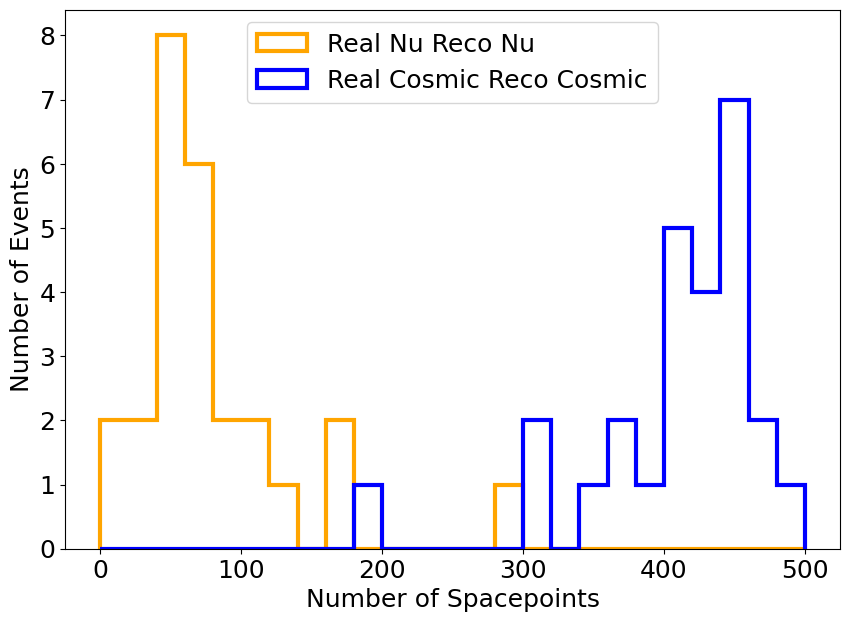

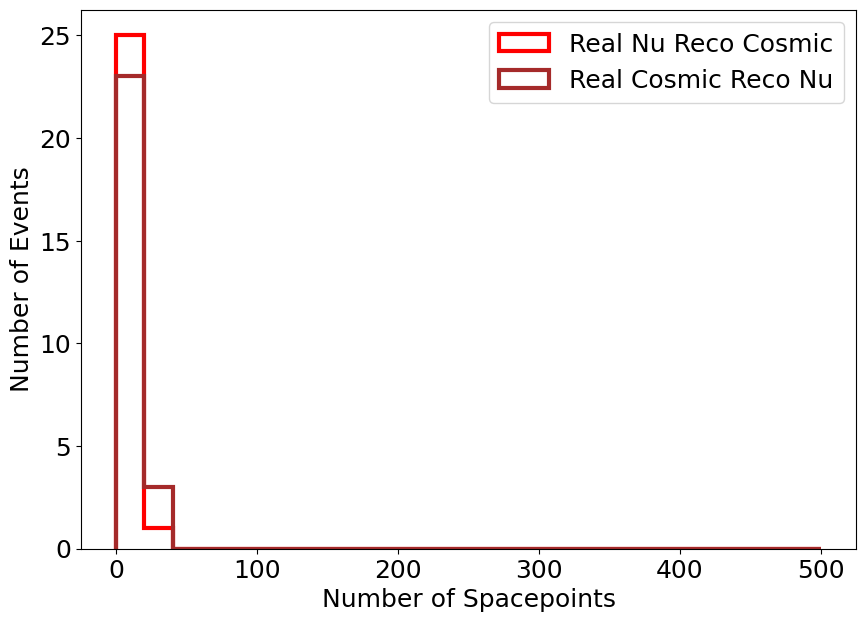

In [19]:
num_real_nu_reco_nu_spacepoints = []
num_real_nu_reco_cosmic_spacepoints = []
num_real_cosmic_reco_nu_spacepoints = []
num_real_cosmic_reco_cosmic_spacepoints = []

for event_i in range(num_events):
    num_real_nu_reco_nu_spacepoints.append(len(real_nu_reco_nu_downsampled_spacepoints[event_i]))
    num_real_nu_reco_cosmic_spacepoints.append(len(real_nu_reco_cosmic_downsampled_spacepoints[event_i]))
    num_real_cosmic_reco_nu_spacepoints.append(len(real_cosmic_reco_nu_downsampled_spacepoints[event_i]))
    num_real_cosmic_reco_cosmic_spacepoints.append(len(real_cosmic_reco_cosmic_downsampled_spacepoints[event_i]))

    if len(real_nu_reco_cosmic_downsampled_spacepoints[event_i]) > 10:
        print(event_i, len(real_nu_reco_cosmic_downsampled_spacepoints[event_i]))

bins = np.linspace(0, 500, 26)
lw = 3

num_real_nu_reco_nu_spacepoints_overflow = np.clip(num_real_nu_reco_nu_spacepoints, 0, bins[-1] - 0.01)
num_real_cosmic_reco_cosmic_spacepoints_overflow = np.clip(num_real_cosmic_reco_cosmic_spacepoints, 0, bins[-1] - 0.01)
num_real_nu_reco_cosmic_spacepoints_overflow = np.clip(num_real_nu_reco_cosmic_spacepoints, 0, bins[-1] - 0.01)
num_real_cosmic_reco_nu_spacepoints_overflow = np.clip(num_real_cosmic_reco_nu_spacepoints, 0, bins[-1] - 0.01)

plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(10, 7))
plt.hist(num_real_nu_reco_nu_spacepoints_overflow, bins=bins, histtype='step', lw=lw, color='orange', label='Real Nu Reco Nu')
plt.hist(num_real_cosmic_reco_cosmic_spacepoints_overflow, bins=bins, histtype='step', lw=lw, color='blue', label='Real Cosmic Reco Cosmic')
plt.legend()
plt.xlabel('Number of Spacepoints')
plt.ylabel('Number of Events')
plt.show()

plt.figure(figsize=(10, 7))
plt.hist(num_real_nu_reco_cosmic_spacepoints_overflow, bins=bins, histtype='step', lw=lw, color='red', label='Real Nu Reco Cosmic')
plt.hist(num_real_cosmic_reco_nu_spacepoints_overflow, bins=bins, histtype='step', lw=lw, color='brown', label='Real Cosmic Reco Nu')
plt.legend()
plt.xlabel('Number of Spacepoints')
plt.ylabel('Number of Events')
plt.show()


# Plot in 3D

In [20]:
include_non_downsampled_points = True

index = 1

run = rse[index, 0]
subrun = rse[index, 1]
event = rse[index, 2]

fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'scene'}]])

# these are only added to set the camera at a better position
fig.add_trace(go.Scatter3d(
    x=expanded_detector_boundary_points[:, 2],
    y=expanded_detector_boundary_points[:, 0],
    z=expanded_detector_boundary_points[:, 1],
    mode='markers',
    marker=dict(
        size=0.2,
        color='black',
        opacity=0.8
    ),
    name='Expanded TPC Boundary'
))

fig.add_trace(go.Scatter3d(
    x=detector_boundary_points[:, 2],
    y=detector_boundary_points[:, 0],
    z=detector_boundary_points[:, 1],
    mode='markers',
    marker=dict(
        size=1,
        color='black',
        opacity=0.8
    ),
    name='TPC Boundary'
))

fig.add_trace(go.Scatter3d(
    x=[reco_nu_vtx[index][2]],
    y=[reco_nu_vtx[index][0]],
    z=[reco_nu_vtx[index][1]],
    mode='markers',
    marker=dict(size=10, color='purple', opacity=1),
    name='Reco Neutrino Vertex',
    visible='legendonly'
))

fig.add_trace(go.Scatter3d(
    x=[true_nu_vtx[index][2]],
    y=[true_nu_vtx[index][0]],
    z=[true_nu_vtx[index][1]],
    mode='markers',
    marker=dict(size=10, color='green', opacity=1),
    name='True Neutrino Vertex',
    visible='legendonly'

))


if include_non_downsampled_points:
    fig.add_trace(go.Scatter3d(
        x=Tcluster_spacepoints[index][:, 2],
        y=Tcluster_spacepoints[index][:, 0],
        z=Tcluster_spacepoints[index][:, 1],
        mode='markers',
        marker=dict(
            size=1,
            color="blue",
            opacity=0.8
        ),
        name='Tcluster Spacepoints',
        visible='legendonly'
    ))

fig.add_trace(go.Scatter3d(
    x=downsampled_Tcluster_spacepoints[index][:, 2],
    y=downsampled_Tcluster_spacepoints[index][:, 0],
    z=downsampled_Tcluster_spacepoints[index][:, 1],
    mode='markers',
    marker=dict(
        size=1,
        color="blue",
        opacity=0.8
    ),
    name='Downsampled Tcluster Spacepoints',
    visible='legendonly'
))

if include_non_downsampled_points:
    fig.add_trace(go.Scatter3d(
        x=Trec_spacepoints[index][:, 2],
        y=Trec_spacepoints[index][:, 0],
        z=Trec_spacepoints[index][:, 1],
        mode='markers',
        marker=dict(
            size=1,
            color='red',
            opacity=0.8
        ),
        name='Trec Spacepoints',
        visible='legendonly'
    ))

fig.add_trace(go.Scatter3d(
    x=downsampled_Trec_spacepoints[index][:, 2],
    y=downsampled_Trec_spacepoints[index][:, 0],
    z=downsampled_Trec_spacepoints[index][:, 1],
    mode='markers',
    marker=dict(
        size=1,
        color='red',
        opacity=0.8
    ),
    name='Downsampled Trec Spacepoints',
    visible='legendonly'
))

if include_non_downsampled_points:
    fig.add_trace(go.Scatter3d(
        x=TrueEDep_spacepoints[index][:, 2],
        y=TrueEDep_spacepoints[index][:, 0],
        z=TrueEDep_spacepoints[index][:, 1],
        mode='markers',
        marker=dict(
            size=1,
            color='orange',
            opacity=0.8
        ),
        name='TrueEDep Spacepoints',
        visible='legendonly'
    ))

fig.add_trace(go.Scatter3d(
    x=downsampled_TrueEDep_spacepoints[index][:, 2],
    y=downsampled_TrueEDep_spacepoints[index][:, 0],
    z=downsampled_TrueEDep_spacepoints[index][:, 1],
    mode='markers',
    marker=dict(
        size=3,
        color='orange',
        opacity=0.8
    ),
    name='Downsampled TrueEDep Spacepoints',
    visible='legendonly'
))

fig.add_trace(go.Scatter3d(
    x=real_nu_reco_nu_downsampled_spacepoints[index][:, 2],
    y=real_nu_reco_nu_downsampled_spacepoints[index][:, 0],
    z=real_nu_reco_nu_downsampled_spacepoints[index][:, 1],
    mode='markers',
    marker=dict(
        size=3,
        color='orange',
        opacity=0.8
    ),
    name='Real Nu Reco Nu Spacepoints',
))

fig.add_trace(go.Scatter3d(
    x=real_nu_reco_cosmic_downsampled_spacepoints[index][:, 2],
    y=real_nu_reco_cosmic_downsampled_spacepoints[index][:, 0],
    z=real_nu_reco_cosmic_downsampled_spacepoints[index][:, 1],
    mode='markers',
    marker=dict(
        size=3,
        color='red',
        opacity=0.8
    ),
    name='Real Nu Reco Cosmic Spacepoints',
))

fig.add_trace(go.Scatter3d(
    x=real_cosmic_reco_nu_downsampled_spacepoints[index][:, 2],
    y=real_cosmic_reco_nu_downsampled_spacepoints[index][:, 0],
    z=real_cosmic_reco_nu_downsampled_spacepoints[index][:, 1],
    mode='markers',
    marker=dict(
        size=3,
        color='brown',
        opacity=0.8
    ),
    name='Real Cosmic Reco Nu Spacepoints',
))

fig.add_trace(go.Scatter3d(
    x=real_cosmic_reco_cosmic_downsampled_spacepoints[index][:, 2],
    y=real_cosmic_reco_cosmic_downsampled_spacepoints[index][:, 0],
    z=real_cosmic_reco_cosmic_downsampled_spacepoints[index][:, 1],
    mode='markers',
    marker=dict(
        size=3,
        color='blue',
        opacity=0.8
    ),
    name='Real Cosmic Reco Cosmic Spacepoints',
))

fig.update_layout(
    scene=dict(
        xaxis_title='z',
        yaxis_title='x',
        zaxis_title='y',
        aspectratio=dict(
            x=5,
            y=3,
            z=1
        ),
    ),
    width=2000,
    height=1200,
    autosize=False,
    scene_camera=dict(
        eye=dict(x=-1.5, y=-1.5, z=1.5)
    )
)

fig.show(renderer="browser")
